In [1]:
%pip install requests
%pip install bs4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:

from disc_scrape.disc_scrape import discipline_scrape


In [2]:
ds = discipline_scrape("Computer Science and Engineering")

Scraper initiated. Default discipline is set to Computer Science and Engineering
Dumping scraped data to /Users/progyan/FourierEpicycles


In [3]:
ds.scrape_and_dump()

avhishek.jpg
anirban.jpg
balagopal.jpg
bireswar.jpg
1-krishna.jpg
Skipped.
mayank.jpg
neeldhara1.jpg
nipun.jpg
sameer.jpg
1_shanmuganathan.jpg
yogesh.jpg


In [4]:
import numpy as np
import cv2 as cv2
from matplotlib import pyplot as plt
img = cv2.imread('./data/1_shanmuganathan.jpg')
# mask = np.zeros(img.shape[:2],np.uint8)
# bgdModel = np.zeros((1,65),np.float64)
# fgdModel = np.zeros((1,65),np.float64)
# rect = (50,50,450,290)
# cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
# mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
# img = img*mask2[:,:,np.newaxis]
def bgremove2(myimage):
    # First Convert to Grayscale
    myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
 
    ret,baseline = cv2.threshold(myimage_grey,127,255,cv2.THRESH_TRUNC)
 
    ret,background = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY)
 
    ret,foreground = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY_INV)
 
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
    return finalimage

In [5]:
img2 = bgremove2(img)

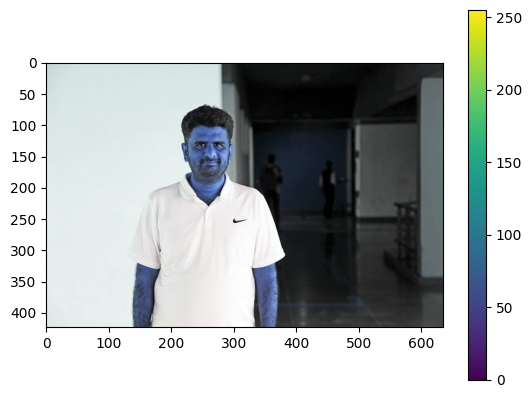

In [6]:
plt.imshow(img),plt.colorbar(),plt.show()
def showimage(myimage):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
         
    fig, ax = plt.subplots(figsize=[10,10])
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

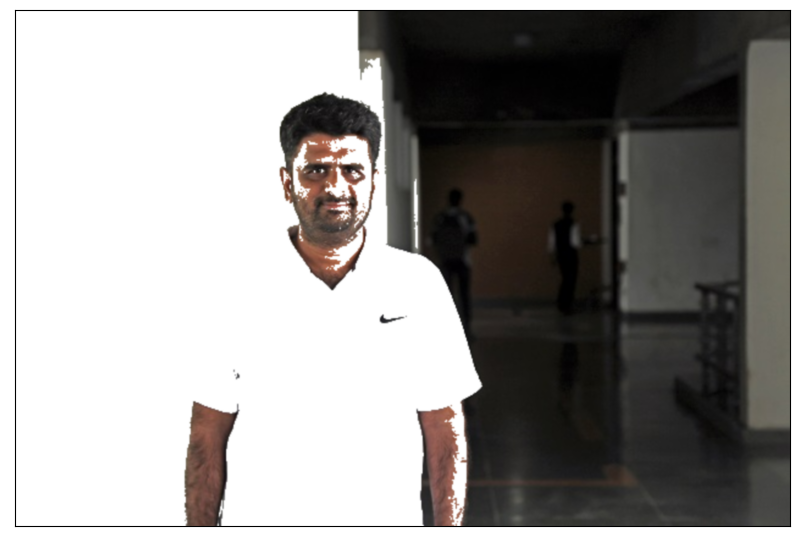

In [7]:
showimage(img2)

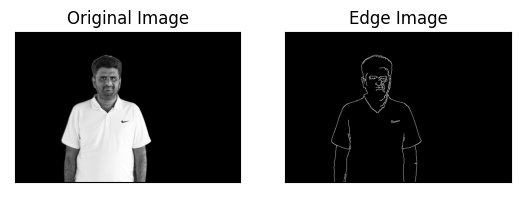

In [17]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('./output.png',0)
edges = cv.Canny(img,400,150)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
import random
import numpy as np
import manim as mn
from svg.path import parse_path

def integrate(func, a, b, *, dx=0.01):
    return sum(func(x) * dx for x in np.arange(a, b, dx))

class SVGPath(mn.VMobject):
    def __init__(self, path_str, *, num_points=500, **kwargs):
        self.path       = parse_path(path_str)
        self.num_points = num_points

        super().__init__(**kwargs)

    def point(self, alpha):
        z = self.path.point(alpha)

        return np.array([z.real, z.imag, 0])

    def generate_points(self):
        step = 1 / self.num_points

        points = [self.point(x) for x in np.arange(0, 1, step)]
        self.start_new_path(points[0])
        self.add_points_as_corners(points[1:])
        self.add_line_to(self.point(1))

        self.flip(mn.RIGHT)
        self.center()

        return self

class Epicycle(mn.VMobject):
    def __init__(self, path, coeff_start, coeff_end=None, *, num_points=500, **kwargs):
        self.num_points = num_points

        if coeff_end is None:
            coeff_end   = int(np.ceil(coeff_start / 2))
            coeff_start = coeff_end - coeff_start

        self.coeffs = self.gen_fourier_coeffs(path, coeff_start, coeff_end)

        super().__init__(**kwargs)

    def generate_points(self):
        step = 1 / self.num_points

        points = [self.point(x) for x in np.arange(0, 1, step)]
        self.start_new_path(points[0])
        self.add_points_as_corners(points[1:])
        self.add_line_to(points[0])

        return self

    def point(self, alpha):
        z = sum(radius * np.exp(alpha * speed * mn.TAU * 1j) for speed, radius in self.coeffs.items())

        return np.array([z.real, z.imag, 0])

    def gen_fourier_coeffs(self, path, start, end):
        def point(alpha):
            pt = path.point_from_proportion(alpha) - path.get_center()

            return complex(pt[0], pt[1])

        # speed: radius
        return {i: integrate(lambda x: point(x) * np.exp(x * -i * mn.TAU * 1j), 0, 1) for i in range(start, end)}

    def draw_circles(self, alpha, whole_mobject=None, **kwargs):
        if whole_mobject is None:
            whole_mobject = self.copy()

        self.submobjects.clear()

        self.pointwise_become_partial(whole_mobject, 0, alpha)

        speeds_and_radii = sorted(self.coeffs.items(), key=lambda x: abs(x[1]), reverse=True)

        z = 0
        for speed, radius in speeds_and_radii:
            circ = mn.Circle(**kwargs)
            circ.scale(abs(radius))
            circ.move_to([z.real, z.imag, 0])
            self.add(circ)

            z += radius * np.exp(alpha * speed * mn.TAU * 1j)

        return self

    def animate_circles(self, **kwargs):
        class Draw(mn.Animation):
            def interpolate_submobject(self, submobject, starting_submobject, alpha):
                submobject.draw_circles(alpha, starting_submobject, **kwargs)

        return Draw(self)

class EpicCycle(mn.Scene):
    path_str = "M 2.614456,0.04305907 C -0.03519642,-0.05013041 0.29631932,2.7704015 0.38598443,2.8585255 L 1.2958347,1.8249996 1.1244138,1.2725989 1.2958347,1.8249996 2.2979871,0.55982315 1.7046078,1.3795156 2.1397537,1.3438767 1.7046078,1.3795156 -0.00960316,3.482204 0.1090739,3.678218 0.5969637,3.0010812 c 0.0566946,0.085227 -0.0821144,-0.036163 0,0 1.896299,0.8350973 2.1009769,-2.94190352 2.0174923,-2.95802213 z"

    def construct(self):
        # Scale because I don't want to edit the SVG because I'm lazy
        path = SVGPath(self.path_str).scale(1.75)
        path.set_color(mn.RED).set_opacity(0.5)

        self.add(path)

        for num_coeffs in range(5, 105 + 1, 20):
            ep = Epicycle(path, num_coeffs)
            ep_copy = ep.copy().draw_circles(0, color=mn.BLUE)

            text = mn.Tex(f"Cycles: {num_coeffs}").to_edge(mn.UP).shift(mn.LEFT)

            self.play(mn.FadeIn(mn.VGroup(ep_copy, text)), run_time=0.75)
            self.remove(ep_copy)

            self.play(ep.animate_circles(color=mn.BLUE), run_time=10, rate_func=mn.linear)

            self.play(mn.FadeOut(mn.VGroup(ep, text)))

ModuleNotFoundError: No module named 'manim'

In [16]:
from rembg import remove

input_path = './data/1_shanmuganathan.jpg'
output_path = 'output.png'

with open(input_path, 'rb') as i:
    with open(output_path, 'wb') as o:
        input = i.read()
        output = remove(input)
        o.write(output)

In [1]:
import os

# folder path
from config.definitions import ROOT_DIR

res = []

for path in os.listdir(ROOT_DIR+"/data/"):
    if os.path.isfile(os.path.join(ROOT_DIR+"/data", path)):
        res.append(path)
print(res)

['joycee.jpg', 'yogesh.jpg', 'avhishek.jpg', 'pallavi.png', 'balagopal.jpg', 'himanshu.jpg', 'anirban.jpg', '1_shanmuganathan.jpg', 'nipun.jpg', '1arup.jpg', '1krishna.jpg', 'mayank.jpg', 'raghubir_sharan1.jpg', 'uttama.jpg', 'jhuma.jpg', 'neeldhara1.jpg', 'nithin.jpg', 'anand.png', 'nihar.jpg', '1-krishna.jpg', 'sameer.jpg', 'bireswar.jpg']


In [1]:
from image_process.image_process import image_process

img = image_process()

Image processing started. Reading from /Users/progyan/FourierEpicycles/data/, writing to /Users/progyan/FourierEpicycles/processed_data/.


In [2]:
img_list = img.return_img_list()

In [3]:
# img.remove_background(img_list=img_list)
# img.edge_detect()

KeyboardInterrupt: 

In [4]:
img.edge_detect(img_list=img_list)

error: OpenCV(4.6.0) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:730: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'
